# Growth Deployment Calculations
We will think of the need for reactors in terms of their power capacity. When a LWR is retired, it will be replaced by an equivalent capacity of the advanced reactor models considered in the work.

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib
from collections import defaultdict
matplotlib.use
import matplotlib.pyplot as plt
plt.style.use('../plotting.mplstyle')

In [2]:
sys.path.insert(0,'../../../scripts')

In [3]:
import reactor_deployment as dep
import scenario_definitions as sd

## First, pull in the LWR data

In [4]:
# read in the LWR deployment data so we can establish a baseline.
lwr_df = pd.read_csv('lwr_info.csv')

# Remove the 'Unnamed: 0' column
lwr_df = lwr_df.drop('Unnamed: 0', axis=1)

In [5]:
# create the simulation retirement year (either the actual retirement or 80
# years after the startup year)
lwr_df['retirement_year'] = lwr_df['Actual retirement (year)'].fillna(
    lwr_df['Startup date (year) b'] + 80)

In [6]:
lwr_df

,Reactor name,State,Reactor type,Reactor vendora,Core size (number of assemblies),Startup date (year) b,License expiration (year),Actual retirement (year),power_cap,retirement_year
0,Arkansas Nuclear One 1,AR,PWR,B&W,177,1974,2034,NaN,836.0,2054.0
1,Arkansas Nuclear One 2,AR,PWR,CE,177,1978,2038,NaN,988.0,2058.0
2,Beaver Valley 1,PA,PWR,WE,157,1976,2036,NaN,908.0,2056.0
3,Beaver Valley 2,PA,PWR,WE,157,1987,2047,NaN,905.0,2067.0
4,Big Rock Point,MI,BWR,GE,84,1964,NaN,1997.0,67.0,1997.0
...,...,...,...,...,...,...,...,...,...,...
116,Yankee Rowe,MA,PWR,WE,76,1960,NaN,1991.0,167.0,1991.0
117,Zion 1,IL,PWR,WE,193,1973,NaN,1997.0,1040.0,1997.0
118,Zion 2,IL,PWR,WE,193,1973,NaN,1996.0,1040.0,1996.0
119,Vogtle 3,GA,PWR,WE,193,2023,2062,NaN,1117.0,2103.0


In [7]:
capacity_change = {year: 0 for year in range(sd.sim_start_yr, sd.sim_end_yr)}

# calculate the decommissioned capacity for each retirement year
for year, power in zip(lwr_df['retirement_year'], lwr_df['power_cap']):
    capacity_change[int(year)] -= power * sd.lwr_capacity_factor

# calculate the commissioned LWR capacity for each startup year
for year, power in zip(lwr_df['Startup date (year) b'], lwr_df['power_cap']):
    capacity_change[int(year)] += power * sd.lwr_capacity_factor

/home/nsryan/anaconda3/envs/cyclus/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


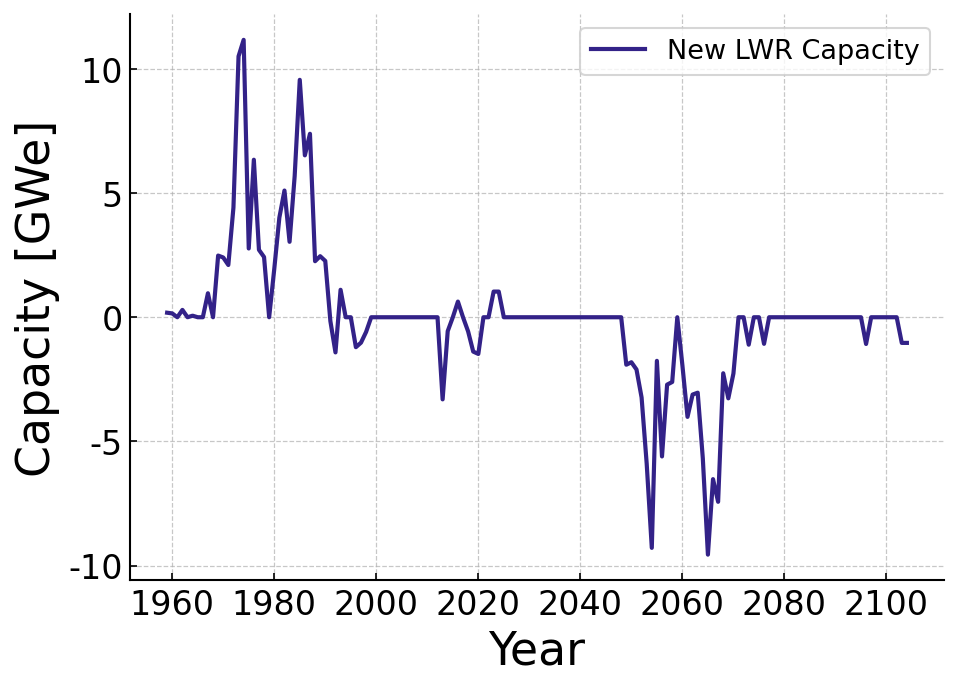

In [8]:
# Convert to a pandas DataFrame and plot.
capacity_change_df = pd.DataFrame(capacity_change.values(), index=capacity_change.keys(), columns=['new_LWR_Capacity'])
capacity_change_df.plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('New LWR Capacity')

In [9]:
# create a total lwr capacity column
capacity_change_df['Total LWR Capacity'] = capacity_change_df['new_LWR_Capacity'].cumsum()

/home/nsryan/anaconda3/envs/cyclus/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


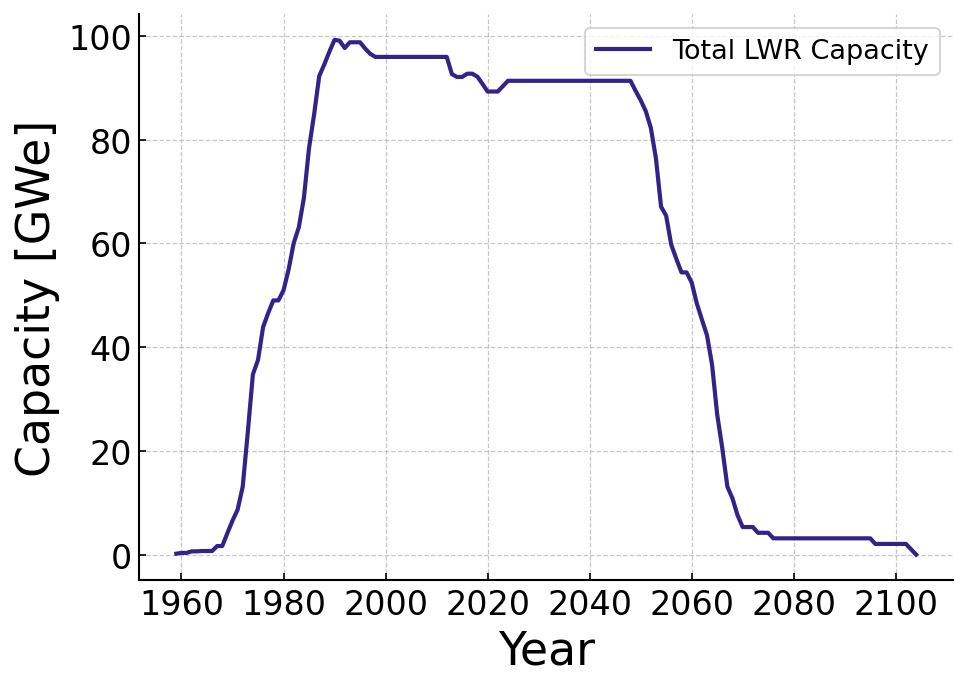

In [10]:
capacity_change_df[["Total LWR Capacity"]].plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('Total LWR Capacity')

## Capacity Expansion Calculations
In this section, I will perform the calculations required to do the energy demand increase. We will use the capacity from the transition_year variable in `scenario_definitions.py`

In [11]:
base_capacity = capacity_change_df.loc[sd.transition_year, 'Total LWR Capacity'] # in MWe

print(f"Total LWR capacity in {sd.transition_year}: {base_capacity} MWe")

Total LWR capacity in 2029: 91345.6 MWe


In [13]:
def capacity_increase(df, base_col, rate, start_year=sd.transition_year, end_year=sd.sim_end_yr):
    """
    This function takes in an increase rate, and creates a new column in the dataframe populated with the increased capacity.

    Parameters
    ----------
    df : pandas DataFrame
        The dataframe to add the new column to.
    base_col : str
        The name of the column to use as the base capacity.
        This column should contain the net capacity.
    rate : float
        The percentage of change in capacity year-to-year
        (e.g. 1.01 for a 1% increase).
    start_year : int
        The year to start the increase.
    end_year : int
        The year to end the increase.

    Returns
    -------
    df : pandas DataFrame
        The dataframe with the new column added.
    """
    for year in range(start_year, end_year):
        df.loc[year, f"{base_col} Inc {rate}"] = \
            df.loc[start_year, base_col] * (rate)**(year - start_year)

    for year in range(df.index[0], start_year):
        df.loc[year, f"{base_col} Inc {rate}"] = df.loc[year, base_col]

    df[f"New Capacity Inc {rate}"] = df[f"{base_col} Inc {rate}"] - df[base_col]
    return df

In [14]:
test_df = capacity_change_df.copy()
capacity_increase(test_df, 'Total LWR Capacity', 1.01)

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1.01,New Capacity Inc 1.01
1959,182.225,1.822250e+02,182.225000,0.000000
1960,154.475,3.367000e+02,336.700000,0.000000
1961,0.000,3.367000e+02,336.700000,0.000000
1962,296.000,6.327000e+02,632.700000,0.000000
1963,0.000,6.327000e+02,632.700000,0.000000
...,...,...,...,...
2100,0.000,2.066450e+03,185142.093984,183075.643984
2101,0.000,2.066450e+03,186993.514923,184927.064923
2102,0.000,2.066450e+03,188863.450073,186797.000073
2103,-1033.225,1.033225e+03,190752.084573,189718.859573


/home/nsryan/anaconda3/envs/cyclus/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


Text(0, 0.5, 'Capacity [GWe]')

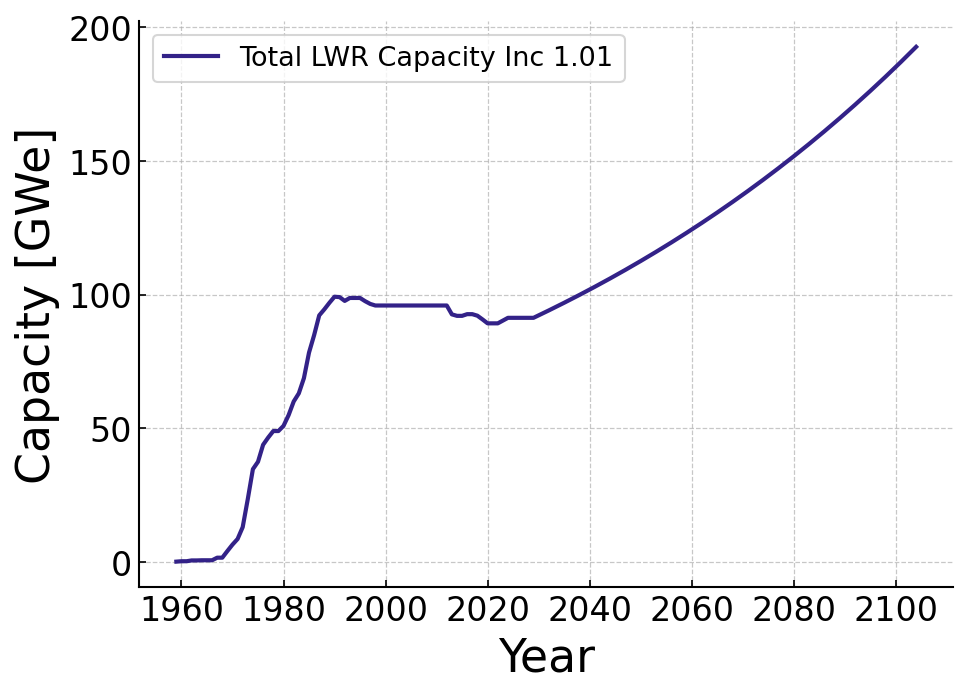

In [15]:
test_df[['Total LWR Capacity Inc 1.01']].plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

# No Growth Scenarios
Growth Rate: 1

In this section, we will use the functions in `reactor_deployment.py` to deploy the advanced reactors to meet demand.

In [16]:
no_growth_cap_df = capacity_change_df.copy()
capacity_increase(no_growth_cap_df, 'Total LWR Capacity', 1)

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,New Capacity Inc 1
1959,182.225,1.822250e+02,182.225,0.000
1960,154.475,3.367000e+02,336.700,0.000
1961,0.000,3.367000e+02,336.700,0.000
1962,296.000,6.327000e+02,632.700,0.000
1963,0.000,6.327000e+02,632.700,0.000
...,...,...,...,...
2100,0.000,2.066450e+03,91345.600,89279.150
2101,0.000,2.066450e+03,91345.600,89279.150
2102,0.000,2.066450e+03,91345.600,89279.150
2103,-1033.225,1.033225e+03,91345.600,90312.375


/home/nsryan/anaconda3/envs/cyclus/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


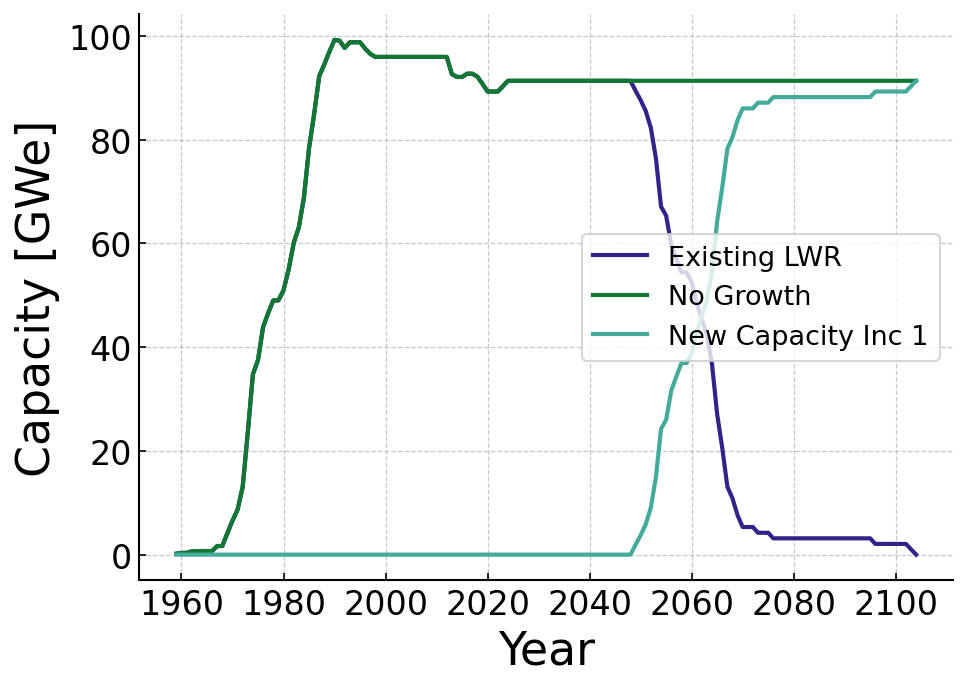

In [17]:
no_growth_cap_df[['Total LWR Capacity','Total LWR Capacity Inc 1','New Capacity Inc 1']].plot()

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('Existing LWR')
legend.get_texts()[1].set_text('No Growth')

## Greedy Deployment

In [18]:
greedy_no_growth_cap_df = no_growth_cap_df.copy()

In [19]:
greedy_no_growth_cap_df

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,New Capacity Inc 1
1959,182.225,1.822250e+02,182.225,0.000
1960,154.475,3.367000e+02,336.700,0.000
1961,0.000,3.367000e+02,336.700,0.000
1962,296.000,6.327000e+02,632.700,0.000
1963,0.000,6.327000e+02,632.700,0.000
...,...,...,...,...
2100,0.000,2.066450e+03,91345.600,89279.150
2101,0.000,2.066450e+03,91345.600,89279.150
2102,0.000,2.066450e+03,91345.600,89279.150
2103,-1033.225,1.033225e+03,91345.600,90312.375


In [20]:
greedy_no_growth_cap_df = greedy_no_growth_cap_df.reset_index().rename(columns={'index':'Year'})

In [21]:
dep.greedy_deployment(greedy_no_growth_cap_df, "New Capacity Inc 1", sd.ad_reactors, sd.transition_year)

,Year,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,New Capacity Inc 1,num_Xe100,num_MMR,Xe100Decom,MMRDecom,total_cap,new_cap,new_Xe100_cap,Xe100_cap,new_MMR_cap,MMR_cap
0,1959,182.225,1.822250e+02,182.225,0.000,0,0,0,0,0,0,0,0,0,0
1,1960,154.475,3.367000e+02,336.700,0.000,0,0,0,0,0,0,0,0,0,0
2,1961,0.000,3.367000e+02,336.700,0.000,0,0,0,0,0,0,0,0,0,0
3,1962,296.000,6.327000e+02,632.700,0.000,0,0,0,0,0,0,0,0,0,0
4,1963,0.000,6.327000e+02,632.700,0.000,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2100,0.000,2.066450e+03,91345.600,89279.150,1115,37,0,22,89385,89275,89200,89200,75,185
142,2101,0.000,2.066450e+03,91345.600,89279.150,1115,24,0,9,89320,89275,89200,89200,75,120
143,2102,0.000,2.066450e+03,91345.600,89279.150,1115,23,0,8,89315,89275,89200,89200,75,115
144,2103,-1033.225,1.033225e+03,91345.600,90312.375,1128,37,0,23,90425,90310,90240,90240,70,185


/home/nsryan/anaconda3/envs/cyclus/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, 'Capacity [GWe]')

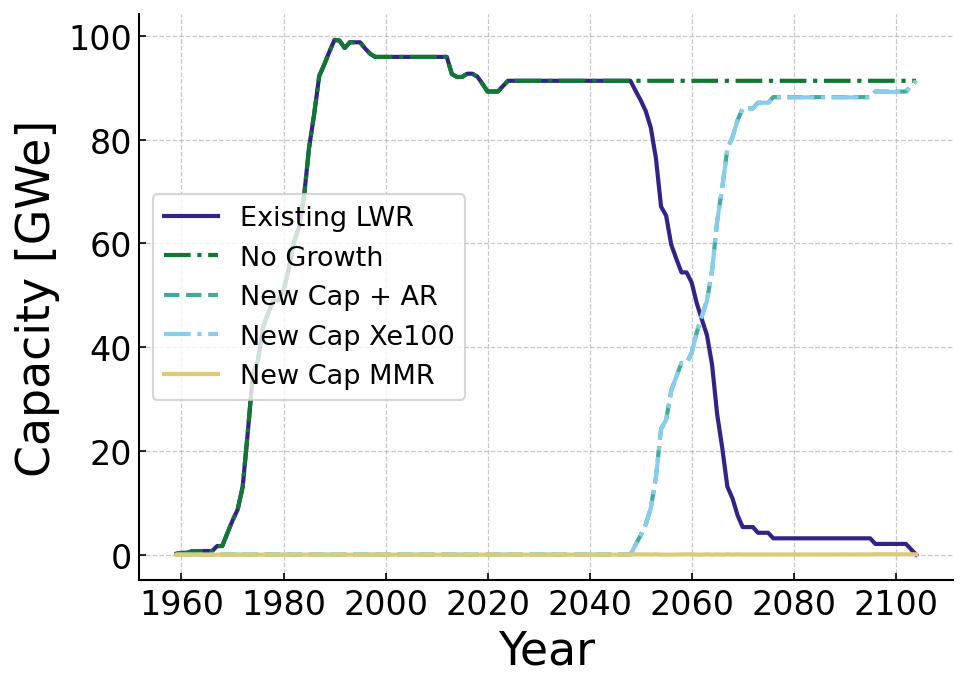

In [22]:
e = ['Year','new_Xe100_cap','new_MMR_cap']
es = ['-','-']

f = ['Year','new_MMR_cap']
fs = ['-']

g = ['Year','Total LWR Capacity','Total LWR Capacity Inc 1','new_cap','new_Xe100_cap','new_MMR_cap']
gs = ['-','-.','--','-.','-']

h = ['Year','num_Xe100', 'num_MMR']
hs = ['-','-']

greedy_no_growth_cap_df[g].plot(x='Year', logy=False, style=gs)


plt.xlabel('Year')

legend = plt.legend()
# g
legend.get_texts()[0].set_text('Existing LWR')
legend.get_texts()[1].set_text('No Growth')
legend.get_texts()[2].set_text('New Cap + AR')
legend.get_texts()[3].set_text('New Cap Xe100')
legend.get_texts()[4].set_text('New Cap MMR')
# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
plt.ylabel('Capacity [GWe]')

# e
# legend.get_texts()[1].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# f
# legend.get_texts()[3].set_text('New Cap Xe100')
# legend.get_texts()[4].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# h
# legend.get_texts()[0].set_text('Xe-100')
# legend.get_texts()[1].set_text('MMR')
# plt.ylabel('Number of Reactors [#]')

In [23]:
dep.analyze_algorithm(greedy_no_growth_cap_df, "Total LWR Capacity Inc 1", "new_cap", sd.ad_reactors)

{'above_count': 0,
 'below_count': 146,
 'equal_count': 0,
 'above_percentage': 0.0,
 'below_percentage': 100.0,
 'total_above': 0.0,
 'total_below': -7772443.999999999,
 'percent_provided': {'Xe100': 99.89685129012294, 'MMR': 0.10314870987706559}}

## Pre Determined Distribution
This section I will skip at the moment as I have not put enough thought into scenarios that would be of interested based on what companies are saying. At present, I think staggering the initial deployment of each technology is the most i can say about the distribution of any specific reactor technology based on the deadlines they are trying to meet.

## Rough Random Deployment
I will only use the rough case as I am not confident the true random case will converge. 

Tolerance will be 5, and the seed will be set for now with the `True` argument.

In [24]:
rrd_no_growth_cap_df = no_growth_cap_df.copy()

In [25]:
rrd_no_growth_cap_df

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,New Capacity Inc 1
1959,182.225,1.822250e+02,182.225,0.000
1960,154.475,3.367000e+02,336.700,0.000
1961,0.000,3.367000e+02,336.700,0.000
1962,296.000,6.327000e+02,632.700,0.000
1963,0.000,6.327000e+02,632.700,0.000
...,...,...,...,...
2100,0.000,2.066450e+03,91345.600,89279.150
2101,0.000,2.066450e+03,91345.600,89279.150
2102,0.000,2.066450e+03,91345.600,89279.150
2103,-1033.225,1.033225e+03,91345.600,90312.375


In [26]:
rrd_no_growth_cap_df = rrd_no_growth_cap_df.reset_index().rename(columns={'index':'Year'})

In [27]:
dep.rand_deployment(rrd_no_growth_cap_df, "New Capacity Inc 1", sd.ad_reactors, sd.transition_year, set_seed=True, rough=True, tolerance=5)

,Year,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,New Capacity Inc 1,num_Xe100,num_MMR,Xe100Decom,MMRDecom,total_cap,new_cap,new_Xe100_cap,Xe100_cap,new_MMR_cap,MMR_cap
0,1959,182.225,1.822250e+02,182.225,0.000,0,0,0,0,0,0,0,0,0,0
1,1960,154.475,3.367000e+02,336.700,0.000,0,0,0,0,0,0,0,0,0,0
2,1961,0.000,3.367000e+02,336.700,0.000,0,0,0,0,0,0,0,0,0,0
3,1962,296.000,6.327000e+02,632.700,0.000,0,0,0,0,0,0,0,0,0,0
4,1963,0.000,6.327000e+02,632.700,0.000,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2100,0.000,2.066450e+03,91345.600,89279.150,1047,2667,0,1570,97095,89245,83760,83760,5485,13335
142,2101,0.000,2.066450e+03,91345.600,89279.150,1047,2715,0,1618,97335,89245,83760,83760,5485,13575
143,2102,0.000,2.066450e+03,91345.600,89279.150,1047,2746,0,1649,97490,89245,83760,83760,5485,13730
144,2103,-1033.225,1.033225e+03,91345.600,90312.375,1058,2814,0,1690,98710,90260,84640,84640,5620,14070


Text(0, 0.5, 'Capacity [GWe]')

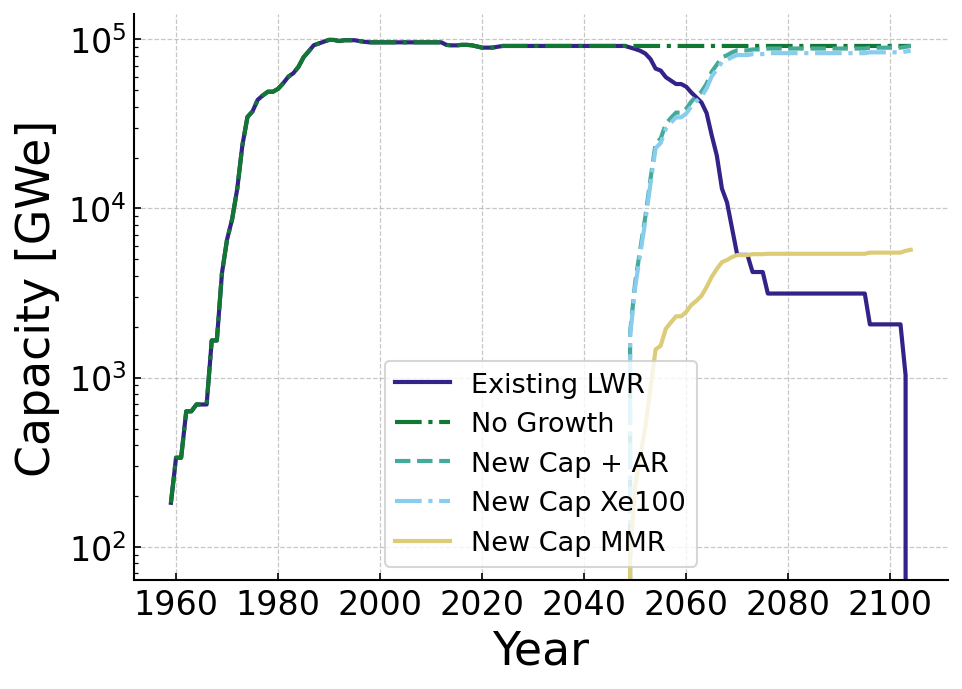

In [28]:
g = ['Year','Total LWR Capacity','Total LWR Capacity Inc 1','new_cap','new_Xe100_cap','new_MMR_cap']
gs = ['-','-.','--','-.','-']

e = ['Year','new_Xe100_cap','new_MMR_cap']
es = ['-','-']

f = ['Year','new_MMR_cap']
fs = ['-']

h = ['Year','num_Xe100', 'num_MMR']
hs = ['-','-']

rrd_no_growth_cap_df[g].plot(x='Year', logy=True, style=gs)

plt.xlabel('Year')

legend = plt.legend()
# g
legend.get_texts()[0].set_text('Existing LWR')
legend.get_texts()[1].set_text('No Growth')
legend.get_texts()[2].set_text('New Cap + AR')
legend.get_texts()[3].set_text('New Cap Xe100')
legend.get_texts()[4].set_text('New Cap MMR')
# Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
plt.ylabel('Capacity [GWe]')

# e
# legend.get_texts()[1].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# f
# legend.get_texts()[3].set_text('New Cap Xe100')
# legend.get_texts()[4].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# h
# legend.get_texts()[0].set_text('Xe-100')
# legend.get_texts()[1].set_text('MMR')
# plt.ylabel('Number of Reactors [#]')

In [29]:
dep.analyze_algorithm(rrd_no_growth_cap_df, "Total LWR Capacity Inc 1", "new_cap", sd.ad_reactors)

{'above_count': 0,
 'below_count': 146,
 'equal_count': 0,
 'above_percentage': 0.0,
 'below_percentage': 100.0,
 'total_above': 0.0,
 'total_below': -7773588.999999999,
 'percent_provided': {'Xe100': 90.166559740635, 'MMR': 9.833440259365013}}

## Rough Random + Greedy

In [30]:
rr_pgd_no_growth_cap_df = no_growth_cap_df.copy()

In [31]:
rr_pgd_no_growth_cap_df = rr_pgd_no_growth_cap_df.reset_index().rename(columns={'index':'Year'})

In [32]:
dep.rand_greedy_deployment(rr_pgd_no_growth_cap_df, "New Capacity Inc 1", sd.ad_reactors, sd.transition_year, set_seed=True)

,Year,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1,New Capacity Inc 1,num_Xe100,num_MMR,Xe100Decom,MMRDecom,total_cap,new_cap,new_Xe100_cap,Xe100_cap,new_MMR_cap,MMR_cap,remaining_cap,greedy_num_Xe100,rand_num_Xe100,greedy_num_MMR,rand_num_MMR
0,1959,182.225,1.822250e+02,182.225,0.000,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0
1,1960,154.475,3.367000e+02,336.700,0.000,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0
2,1961,0.000,3.367000e+02,336.700,0.000,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0
3,1962,296.000,6.327000e+02,632.700,0.000,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0
4,1963,0.000,6.327000e+02,632.700,0.000,0,0,0,0,0,0,0,0,0,0,0.000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2100,0.000,2.066450e+03,91345.600,89279.150,1047,4737,0,2064,204540,107445,83760,83760,13365,23685,34.150,0,1047,2070,2667
142,2101,0.000,2.066450e+03,91345.600,89279.150,1047,4884,0,2163,205515,108180,83760,83760,13605,24420,34.150,0,1047,2169,2715
143,2102,0.000,2.066450e+03,91345.600,89279.150,1047,4977,0,2225,206135,108645,83760,83760,13760,24885,34.150,0,1047,2231,2746
144,2103,-1033.225,1.033225e+03,91345.600,90312.375,1058,5137,0,2313,209035,110325,84640,84640,14120,25685,52.375,0,1058,2323,2814


Text(0, 0.5, 'Capacity [GWe]')

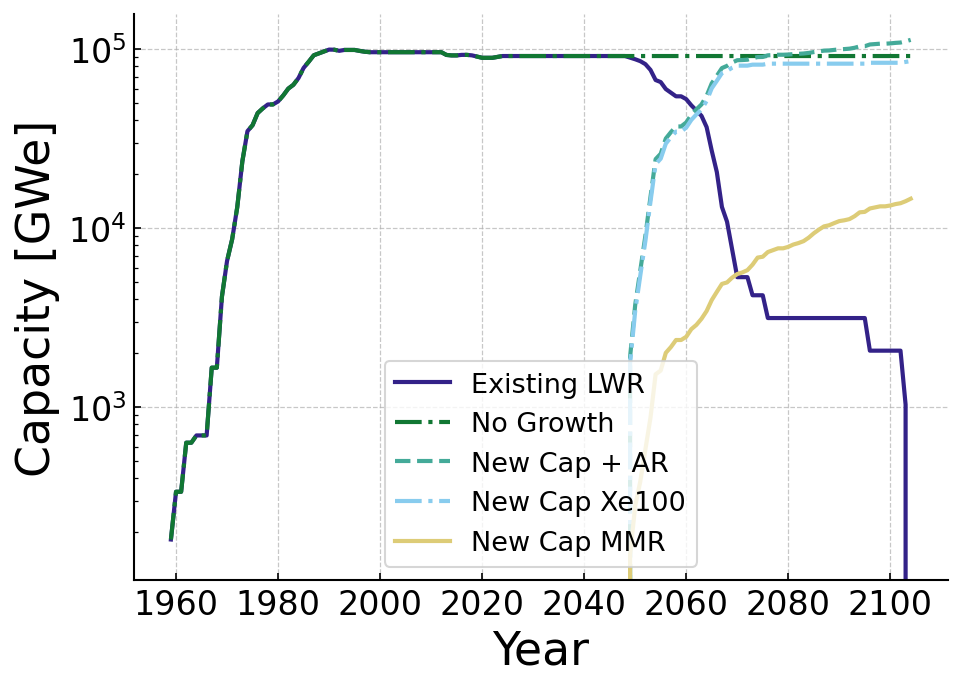

In [33]:
g = ['Year','Total LWR Capacity','Total LWR Capacity Inc 1','new_cap','new_Xe100_cap','new_MMR_cap']
gs = ['-','-.','--','-.','-']

e = ['Year','new_Xe100_cap','new_MMR_cap']
es = ['-','-']

f = ['Year','new_MMR_cap']
fs = ['-']

h = ['Year','num_Xe100', 'num_MMR']
hs = ['-','-']

rr_pgd_no_growth_cap_df[g].plot(x='Year', logy=True, style=gs)

plt.xlabel('Year')

legend = plt.legend()
# g
legend.get_texts()[0].set_text('Existing LWR')
legend.get_texts()[1].set_text('No Growth')
legend.get_texts()[2].set_text('New Cap + AR')
legend.get_texts()[3].set_text('New Cap Xe100')
legend.get_texts()[4].set_text('New Cap MMR')
# Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
plt.ylabel('Capacity [GWe]')

# e
# legend.get_texts()[1].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# f
# legend.get_texts()[3].set_text('New Cap Xe100')
# legend.get_texts()[4].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# h
# legend.get_texts()[0].set_text('Xe-100')
# legend.get_texts()[1].set_text('MMR')
# plt.ylabel('Number of Reactors [#]')

In [34]:
dep.analyze_algorithm(rr_pgd_no_growth_cap_df, "Total LWR Capacity Inc 1", "new_cap", sd.ad_reactors)

{'above_count': 29,
 'below_count': 117,
 'equal_count': 0,
 'above_percentage': 19.863013698630137,
 'below_percentage': 80.13698630136986,
 'total_above': 261552.59999999983,
 'total_below': -7683536.599999997,
 'percent_provided': {'Xe100': 44.05170294434498, 'MMR': 7.092376333981543}}

# Low Growth 
1% growth rate from year to year. 

In [35]:
low_growth_cap_df = capacity_change_df.copy()
capacity_increase(low_growth_cap_df, 'Total LWR Capacity', 1.01)

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1.01,New Capacity Inc 1.01
1959,182.225,1.822250e+02,182.225000,0.000000
1960,154.475,3.367000e+02,336.700000,0.000000
1961,0.000,3.367000e+02,336.700000,0.000000
1962,296.000,6.327000e+02,632.700000,0.000000
1963,0.000,6.327000e+02,632.700000,0.000000
...,...,...,...,...
2100,0.000,2.066450e+03,185142.093984,183075.643984
2101,0.000,2.066450e+03,186993.514923,184927.064923
2102,0.000,2.066450e+03,188863.450073,186797.000073
2103,-1033.225,1.033225e+03,190752.084573,189718.859573


/home/nsryan/anaconda3/envs/cyclus/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


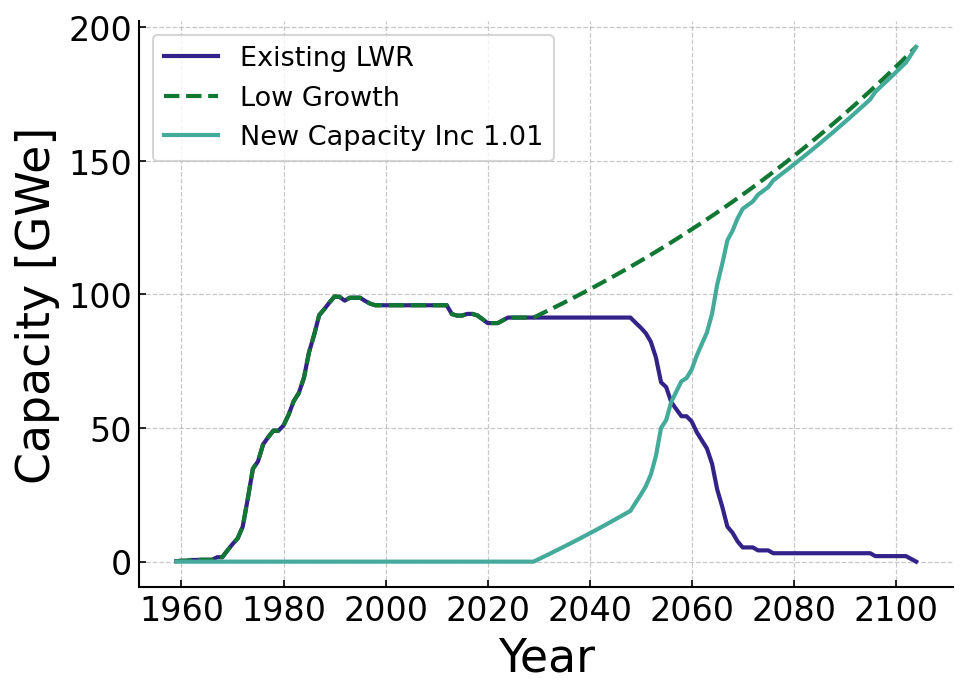

In [36]:
low_growth_cap_df[['Total LWR Capacity','Total LWR Capacity Inc 1.01','New Capacity Inc 1.01']].plot(style=['-','--'])

# Convert from MWe to GWe
plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])

plt.xlabel('Year')
plt.ylabel('Capacity [GWe]')

legend = plt.legend()
legend.get_texts()[0].set_text('Existing LWR')
legend.get_texts()[1].set_text('Low Growth')

## Greedy

In [37]:
greedy_low_growth_cap_df = low_growth_cap_df.copy()
greedy_low_growth_cap_df

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1.01,New Capacity Inc 1.01
1959,182.225,1.822250e+02,182.225000,0.000000
1960,154.475,3.367000e+02,336.700000,0.000000
1961,0.000,3.367000e+02,336.700000,0.000000
1962,296.000,6.327000e+02,632.700000,0.000000
1963,0.000,6.327000e+02,632.700000,0.000000
...,...,...,...,...
2100,0.000,2.066450e+03,185142.093984,183075.643984
2101,0.000,2.066450e+03,186993.514923,184927.064923
2102,0.000,2.066450e+03,188863.450073,186797.000073
2103,-1033.225,1.033225e+03,190752.084573,189718.859573


In [38]:
greedy_low_growth_cap_df = greedy_low_growth_cap_df.reset_index().rename(columns={'index':'Year'})
dep.greedy_deployment(greedy_low_growth_cap_df, "New Capacity Inc 1.01", sd.ad_reactors, sd.transition_year)

,Year,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1.01,New Capacity Inc 1.01,num_Xe100,num_MMR,Xe100Decom,MMRDecom,total_cap,new_cap,new_Xe100_cap,Xe100_cap,new_MMR_cap,MMR_cap
0,1959,182.225,1.822250e+02,182.225000,0.000000,0,0,0,0,0,0,0,0,0,0
1,1960,154.475,3.367000e+02,336.700000,0.000000,0,0,0,0,0,0,0,0,0,0
2,1961,0.000,3.367000e+02,336.700000,0.000000,0,0,0,0,0,0,0,0,0,0
3,1962,296.000,6.327000e+02,632.700000,0.000000,0,0,0,0,0,0,0,0,0,0
4,1963,0.000,6.327000e+02,632.700000,0.000000,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2100,0.000,2.066450e+03,185142.093984,183075.643984,2420,20,132,13,193700,183075,183040,193600,35,100
142,2101,0.000,2.066450e+03,186993.514923,184927.064923,2455,28,144,19,196540,184925,184880,196400,45,140
143,2102,0.000,2.066450e+03,188863.450073,186797.000073,2491,45,157,30,199505,186795,186720,199280,75,225
144,2103,-1033.225,1.033225e+03,190752.084573,189718.859573,2541,40,170,33,203480,189715,189680,203280,35,200


Text(0, 0.5, 'Number of Reactors [#]')

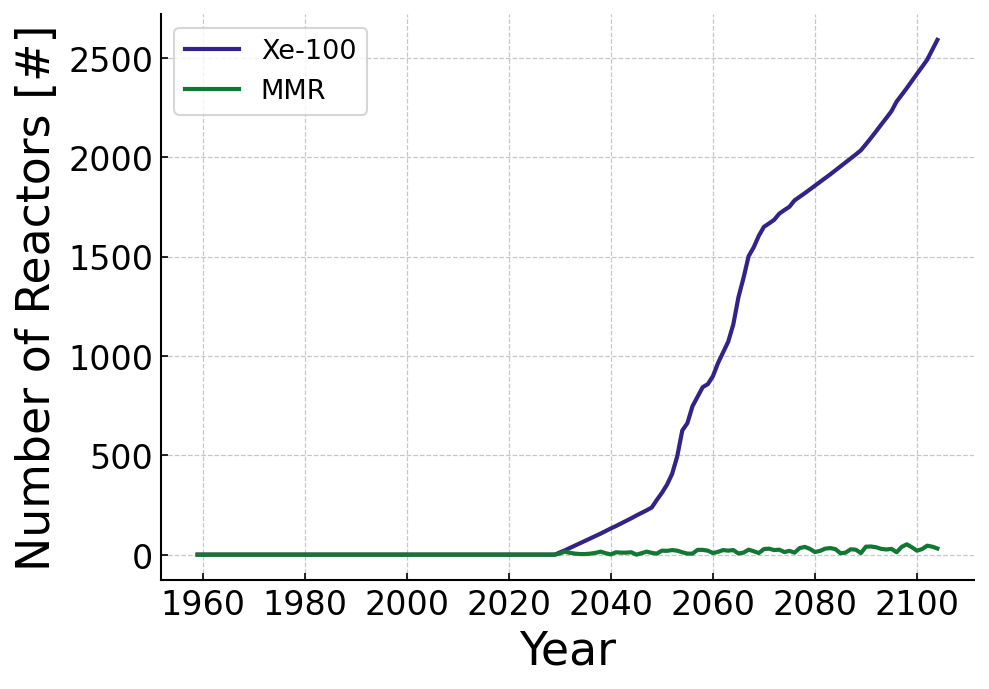

In [39]:
e = ['Year','new_Xe100_cap','new_MMR_cap']
es = ['-','-']

f = ['Year','new_MMR_cap']
fs = ['-']

g = ['Year','Total LWR Capacity','Total LWR Capacity Inc 1.01','new_cap','new_Xe100_cap','new_MMR_cap']
gs = ['-','-.','--','-.','-']

h = ['Year','num_Xe100', 'num_MMR']
hs = ['-','-']

greedy_low_growth_cap_df[h].plot(x='Year', logy=False, style=hs)


plt.xlabel('Year')

legend = plt.legend()
# g
# legend.get_texts()[0].set_text('Existing LWR')
# legend.get_texts()[1].set_text('Low Growth')
# legend.get_texts()[2].set_text('New Cap + AR')
# legend.get_texts()[3].set_text('New Cap Xe100')
# legend.get_texts()[4].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# e
# legend.get_texts()[1].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# f
# legend.get_texts()[3].set_text('New Cap Xe100')
# legend.get_texts()[4].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# h
legend.get_texts()[0].set_text('Xe-100')
legend.get_texts()[1].set_text('MMR')
plt.ylabel('Number of Reactors [#]')

In [40]:
dep.analyze_algorithm(greedy_low_growth_cap_df, "Total LWR Capacity Inc 1.01", "new_cap", sd.ad_reactors)

{'above_count': 0,
 'below_count': 146,
 'equal_count': 0,
 'above_percentage': 0.0,
 'below_percentage': 100.0,
 'total_above': 0.0,
 'total_below': -7772508.547325758,
 'percent_provided': {'Xe100': 99.90309601171738, 'MMR': 0.09690398828262614}}

## Rough Random

In [41]:
rrd_low_growth_cap_df = low_growth_cap_df.copy()
rrd_low_growth_cap_df

,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1.01,New Capacity Inc 1.01
1959,182.225,1.822250e+02,182.225000,0.000000
1960,154.475,3.367000e+02,336.700000,0.000000
1961,0.000,3.367000e+02,336.700000,0.000000
1962,296.000,6.327000e+02,632.700000,0.000000
1963,0.000,6.327000e+02,632.700000,0.000000
...,...,...,...,...
2100,0.000,2.066450e+03,185142.093984,183075.643984
2101,0.000,2.066450e+03,186993.514923,184927.064923
2102,0.000,2.066450e+03,188863.450073,186797.000073
2103,-1033.225,1.033225e+03,190752.084573,189718.859573


In [42]:
rrd_low_growth_cap_df = rrd_low_growth_cap_df.reset_index().rename(columns={'index':'Year'})
dep.rand_deployment(rrd_low_growth_cap_df, "New Capacity Inc 1.01", sd.ad_reactors, sd.transition_year, set_seed=True, rough=True, tolerance=5)

,Year,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1.01,New Capacity Inc 1.01,num_Xe100,num_MMR,Xe100Decom,MMRDecom,total_cap,new_cap,new_Xe100_cap,Xe100_cap,new_MMR_cap,MMR_cap
0,1959,182.225,1.822250e+02,182.225000,0.000000,0,0,0,0,0,0,0,0,0,0
1,1960,154.475,3.367000e+02,336.700000,0.000000,0,0,0,0,0,0,0,0,0,0
2,1961,0.000,3.367000e+02,336.700000,0.000000,0,0,0,0,0,0,0,0,0,0
3,1962,296.000,6.327000e+02,632.700000,0.000000,0,0,0,0,0,0,0,0,0,0
4,1963,0.000,6.327000e+02,632.700000,0.000000,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2100,0.000,2.066450e+03,185142.093984,183075.643984,2269,5190,124,2900,207470,183050,171600,181520,11450,25950
142,2101,0.000,2.066450e+03,186993.514923,184927.064923,2303,5292,136,2981,210700,184915,173360,184240,11555,26460
143,2102,0.000,2.066450e+03,188863.450073,186797.000073,2337,5391,148,3067,213915,186740,175120,186960,11620,26955
144,2103,-1033.225,1.033225e+03,190752.084573,189718.859573,2385,5502,161,3149,218310,189685,177920,190800,11765,27510


Text(0, 0.5, 'Capacity [GWe]')

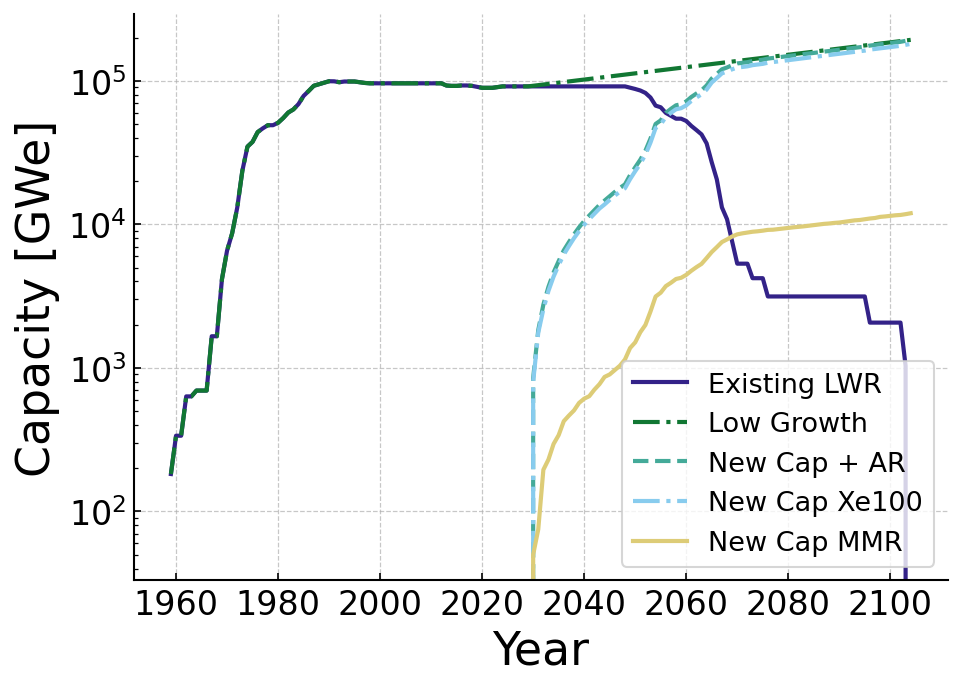

In [43]:
g = ['Year','Total LWR Capacity','Total LWR Capacity Inc 1.01','new_cap','new_Xe100_cap','new_MMR_cap']
gs = ['-','-.','--','-.','-']

e = ['Year','new_Xe100_cap','new_MMR_cap']
es = ['-','-']

f = ['Year','new_MMR_cap']
fs = ['-']

h = ['Year','num_Xe100', 'num_MMR']
hs = ['-','-']

rrd_low_growth_cap_df[g].plot(x='Year', logy=True, style=gs)

plt.xlabel('Year')

legend = plt.legend()
# g
legend.get_texts()[0].set_text('Existing LWR')
legend.get_texts()[1].set_text('Low Growth')
legend.get_texts()[2].set_text('New Cap + AR')
legend.get_texts()[3].set_text('New Cap Xe100')
legend.get_texts()[4].set_text('New Cap MMR')
# Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
plt.ylabel('Capacity [GWe]')

# e
# legend.get_texts()[1].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# f
# legend.get_texts()[3].set_text('New Cap Xe100')
# legend.get_texts()[4].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# h
# legend.get_texts()[0].set_text('Xe-100')
# legend.get_texts()[1].set_text('MMR')
# plt.ylabel('Number of Reactors [#]')

In [44]:
dep.analyze_algorithm(rrd_low_growth_cap_df, "Total LWR Capacity Inc 1.01", "new_cap", sd.ad_reactors)

{'above_count': 0,
 'below_count': 146,
 'equal_count': 0,
 'above_percentage': 0.0,
 'below_percentage': 100.0,
 'total_above': 0.0,
 'total_below': -7775083.547325758,
 'percent_provided': {'Xe100': 89.9597187950058, 'MMR': 10.040281204994194}}

## Rough Random + Greedy

In [45]:
rr_pgd_low_growth_cap_df = low_growth_cap_df.copy()
rr_pgd_low_growth_cap_df = rr_pgd_low_growth_cap_df.reset_index().rename(columns={'index':'Year'})
dep.rand_greedy_deployment(rr_pgd_low_growth_cap_df, "New Capacity Inc 1.01", sd.ad_reactors, sd.transition_year, set_seed=True)

,Year,new_LWR_Capacity,Total LWR Capacity,Total LWR Capacity Inc 1.01,New Capacity Inc 1.01,num_Xe100,num_MMR,Xe100Decom,MMRDecom,total_cap,new_cap,new_Xe100_cap,Xe100_cap,new_MMR_cap,MMR_cap,remaining_cap,greedy_num_Xe100,rand_num_Xe100,greedy_num_MMR,rand_num_MMR
0,1959,182.225,1.822250e+02,182.225000,0.000000,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0
1,1960,154.475,3.367000e+02,336.700000,0.000000,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0
2,1961,0.000,3.367000e+02,336.700000,0.000000,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0
3,1962,296.000,6.327000e+02,632.700000,0.000000,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0
4,1963,0.000,6.327000e+02,632.700000,0.000000,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2100,0.000,2.066450e+03,185142.093984,183075.643984,2393,9253,124,4058,445175,237705,181520,191440,25975,46265,25.643984,124,2269,4063,5190
142,2101,0.000,2.066450e+03,186993.514923,184927.064923,2439,9508,136,4214,453360,242660,184240,195120,26470,47540,12.064923,136,2303,4216,5292
143,2102,0.000,2.066450e+03,188863.450073,186797.000073,2485,9792,148,4390,461675,247760,186960,198800,27010,48960,57.000073,148,2337,4401,5391
144,2103,-1033.225,1.033225e+03,190752.084573,189718.859573,2546,10045,161,4537,472215,253905,190800,203680,27540,50225,33.859573,161,2385,4543,5502


Text(0, 0.5, 'Capacity [GWe]')

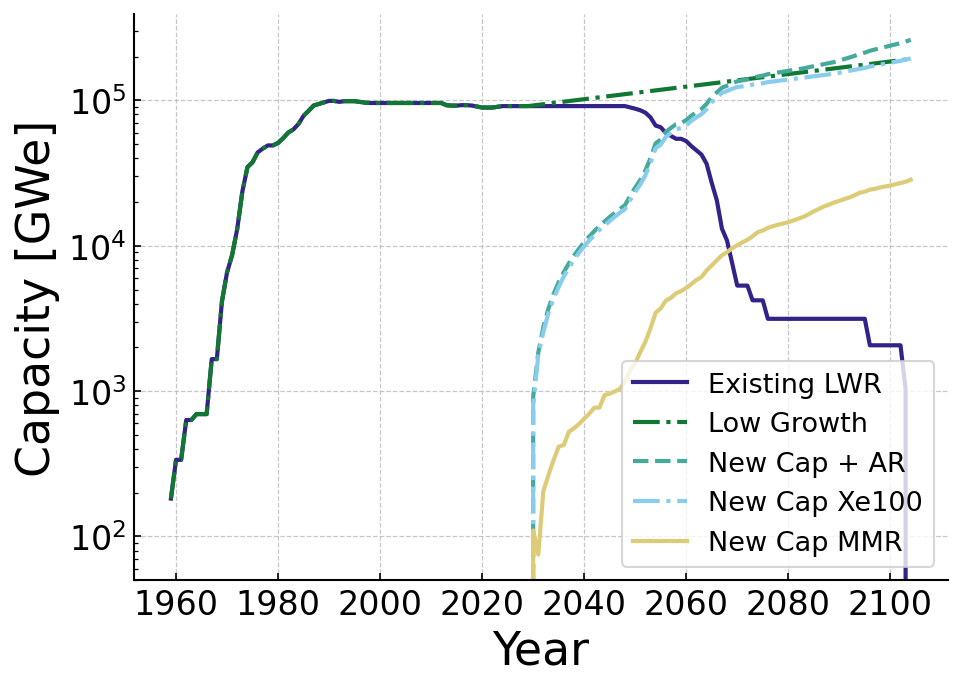

In [46]:
g = ['Year','Total LWR Capacity','Total LWR Capacity Inc 1.01','new_cap','new_Xe100_cap','new_MMR_cap']
gs = ['-','-.','--','-.','-']

e = ['Year','new_Xe100_cap','new_MMR_cap']
es = ['-','-']

f = ['Year','new_MMR_cap']
fs = ['-']

h = ['Year','num_Xe100', 'num_MMR']
hs = ['-','-']

rr_pgd_low_growth_cap_df[g].plot(x='Year', logy=True, style=gs)

plt.xlabel('Year')

legend = plt.legend()
# g
legend.get_texts()[0].set_text('Existing LWR')
legend.get_texts()[1].set_text('Low Growth')
legend.get_texts()[2].set_text('New Cap + AR')
legend.get_texts()[3].set_text('New Cap Xe100')
legend.get_texts()[4].set_text('New Cap MMR')
# Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
plt.ylabel('Capacity [GWe]')

# e
# legend.get_texts()[1].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# f
# legend.get_texts()[3].set_text('New Cap Xe100')
# legend.get_texts()[4].set_text('New Cap MMR')
# # Convert from MWe to GWe
# plt.gca().set_yticklabels([str(int(tick/1000)) for tick in plt.gca().get_yticks()])
# plt.ylabel('Capacity [GWe]')

# h
# legend.get_texts()[0].set_text('Xe-100')
# legend.get_texts()[1].set_text('MMR')
# plt.ylabel('Number of Reactors [#]')

In [47]:
dep.analyze_algorithm(rr_pgd_low_growth_cap_df, "Total LWR Capacity Inc 1.01", "new_cap", sd.ad_reactors)

{'above_count': 32,
 'below_count': 114,
 'equal_count': 0,
 'above_percentage': 21.91780821917808,
 'below_percentage': 78.08219178082192,
 'total_above': 806019.1687366344,
 'total_below': -7644812.716062392,
 'percent_provided': {'Xe100': 44.211259349809374, 'MMR': 7.391609845543401}}